# NSBH parameter estimation with Bilby

This tutorial shows how to use Bilby to analyze the NSBH event GW230529.

Additional examples and tutorials can be found in the Bilby [documentation](https://bilby-dev.github.io/bilby/) and [git repository](https://github.com/bilby-dev/bilby/tree/main/examples).

We begin by installing necessary packages.
For this tutorial, we use a custom version of Bilby that supports JAX acceleration with the sampler jaxted.
These require direct installation from GitHub along with some other packages.

To run an equivalent analysis using the dynesty sampler it is sufficient to include just the following install statement.

```python
!pip install bilby[gw] gwosc
```

## Hardware setup

The sampler/likelihood we will use supports hardware acceleration via JAX, so make sure to set the `Runtime->Change runtime type->T4 GPU`.

In [1]:
!pip install git+https://github.com/ColmTalbot/bilby.git@bilback\
    git+https://github.com/ColmTalbot/jaxted.git@main\
    array-api-compat interpax plum-dispatch gwpy gwosc ripplegw jax_tqdm

  Cloning https://github.com/ColmTalbot/bilby.git (to revision bilback) to /tmp/pip-req-build-a1_r1fhf
  Running command git clone --filter=blob:none --quiet https://github.com/ColmTalbot/bilby.git /tmp/pip-req-build-a1_r1fhf
  Running command git checkout -b bilback --track origin/bilback
  Switched to a new branch 'bilback'
  Branch 'bilback' set up to track remote branch 'bilback' from 'origin'.
  Resolved https://github.com/ColmTalbot/bilby.git to commit 8cd671200eda2601f1a9e5b8098d278e2b26be89
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/ColmTalbot/jaxted.git (to revision main) to /tmp/pip-req-build-xftx8ych
  Running command git clone --filter=blob:none --quiet https://github.com/ColmTalbot/jaxted.git /tmp/pip-req-build-xftx8ych
  Resolved https://github.com/ColmTalbot/jaxted.git to commit 222eee4bbe52c8a955f9c988dcc35dab5729a735
  Installing build dependencies .

## Download data

The data is publicly accessible, but especially the PSDs can be a little painful to extract so I've pre-extracted them.

In [2]:
!gdown https://drive.google.com/uc?id=1tS5SuukAjMAZtjQor29_29OmWLpbr4yV
!gdown https://drive.google.com/uc?id=1z0AKXDOIcXbybcZlC4aZXPfWwt9QLbqF

Downloading...
From: https://drive.google.com/uc?id=1tS5SuukAjMAZtjQor29_29OmWLpbr4yV
To: /content/GW230529_L1_psd.txt
100% 26.2M/26.2M [00:00<00:00, 99.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z0AKXDOIcXbybcZlC4aZXPfWwt9QLbqF
To: /content/GW230529_L1_strain.hdf5
100% 4.02M/4.02M [00:00<00:00, 171MB/s]


In [3]:
import bilby
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bilby.core.prior import Uniform, Sine, Cosine
from bilby.gw.prior import (
    AlignedSpin,
    BBHPriorDict,
    ConditionalChiInPlane,
    UniformInComponentsChirpMass,
    UniformInComponentsMassRatio,
    UniformSourceFrame,
)
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters
from bilby.gw.detector import PowerSpectralDensity, get_empty_interferometer
from bilby.gw.jaxstuff import ripple_bbh
from bilby.gw.result import CBCResult
from gwosc import datasets
from gwpy.timeseries import TimeSeries
from tqdm.auto import tqdm

%matplotlib inline

## Preliminary setup

- We specify to use 64-bit floating point precision in JAX, this is currently necessary when using JAX to avoid overflow issues
- The remainder of this cell is generic for Bilby analyses.

**_Note_**: We set the random seed in both Bilby and numpy to ensure that we have consistent randomness.

In [4]:
jax.config.update("jax_enable_x64", True)

event = "GW230529"
outdir = event
label = f"phenompv2_multiband"

bilby.core.utils.random.seed(230529)
np.random.seed(230529)

## Data acquisition

In this case, I have pre-downloaded the data and PSD from GWOSC and Zenodo respectively.

The PSD is packaged in the PESummary result files released along with the detection paper.

The data can also be queried using

```python
data = TimeSeries.fetch_open_data(
    det,
    start=trigger_time - duration + 2,
    end=trigger_time + 2,
)
```

There are a few JAX specific things here, including converting the data stored in the Interferometer objects to use JAX arrays.

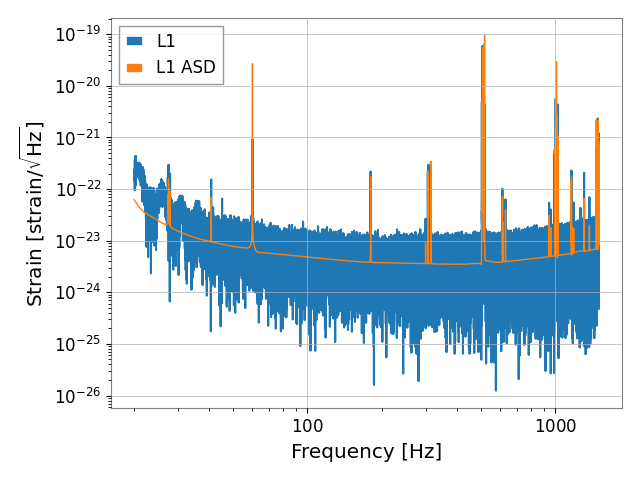

In [5]:
trigger_time = datasets.event_gps(event)
detectors = datasets.event_detectors(event)
maximum_frequency = jnp.array(1500)
minimum_frequency = jnp.array(20)
duration = 128
post_trigger_duration = 2
end_time = trigger_time + post_trigger_duration
start_time = end_time - duration

ifo_list = bilby.gw.detector.InterferometerList([])
for det in detectors:
    ifo = get_empty_interferometer(det)
    ifo.power_spectral_density = PowerSpectralDensity(psd_file=f"GW230529_{det}_psd.txt")

    data = TimeSeries.read(f"GW230529_{det}_strain.hdf5")
    ifo.strain_data.set_from_gwpy_timeseries(data)

    ifo.maximum_frequency = maximum_frequency
    ifo.minimum_frequency = minimum_frequency
    ifo_list.append(ifo)

ifo_list.set_array_backend(jnp)

bilby.core.utils.check_directory_exists_and_if_not_mkdir(outdir)
ifo_list.plot_data(outdir=outdir, label=label)

from IPython.display import Image
Image(filename=f'{outdir}/L1_{label}_frequency_domain_data.png')

## Define the prior

### Masses

To simplify the sampling problem, we sample in the chirp mass and mass ratio.

The prior is separable with this parameterization

$$
\pi(\mathcal{M}) \propto {\cal M}, \, \pi(q) \propto \frac{(1 + q)^{2/5}}{q^{6/5}}
$$

### Spin

For the primary object, we sample in the aligned component of the spin and the magnitude of the in plane spin conditioned on the aligned component.

$$
\begin{align}
\pi(\chi) &= -\frac{1}{2 a_\max}\ln\left(\frac{|\chi|}{a_{\max}}\right) \\
\pi(\chi_{\perp} | \chi) &= \frac{-\chi_{\perp}}{\chi^2 + \chi_{\perp}^2} \frac{1}{\ln\left(\frac{|\chi|}{a_{\max}}\right)}
\end{align}
$$

For the secondary object, we sample in the spin magnitude and tilt.

This choice is somewhat arbitrary and other parameterizations may lead to better convergence depending on the sampling algorithm.

### Extrinsics

For the extrinsic parameters, we use the standard geometrically-motivated distribution.
Since this is a single detector event, we sample in naive sky coordinates.
We sample in the time of arrival at the detector rather than the time at the geocenter to simplify the posterior.

In [6]:
priors = bilby.gw.prior.BBHPriorDict(dict(
    chirp_mass=UniformInComponentsChirpMass(name='chirp_mass', minimum=2, maximum=2.04, unit='$M_{\odot}$'),
    mass_ratio=UniformInComponentsMassRatio(name='mass_ratio', minimum=0.05, maximum=1),
    chi_1=AlignedSpin(name='chi_1', minimum=-0.99, maximum=0.99, unit='$\chi_1$'),
    chi_1_in_plane=ConditionalChiInPlane(name='chi_1_in_plane', minimum=0, maximum=0.99, unit='$\chi_{1,\mathrm{in}}$'),
    a_2=Uniform(name='a_2', minimum=0, maximum=0.05),
    tilt_2=Sine(name='tilt_2'),
    phi_12=Uniform(name='phi_12', minimum=0, maximum=2 * np.pi, boundary='periodic'),
    phi_jl=Uniform(name='phi_jl', minimum=0, maximum=2 * np.pi, boundary='periodic'),
    luminosity_distance=UniformSourceFrame(name='luminosity_distance', minimum=1, maximum=600, unit='Mpc', latex_label='$d_L$'),
    dec=Cosine(name='dec'),
    ra=Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic'),
    theta_jn=Sine(name='theta_jn'),
    psi=Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic'),
    phase=Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic'),
    L1_time=Uniform(trigger_time - 0.1, trigger_time + 0.1, name="L1_time"),
))

## Waveform generator

The last major component we need to specify is the waveform generation method.
There are two customizations here specific to the JAX sampler we will use:
- we use a waveform model implemented in ripple.
- we specify `use_cache=False` (a new feature in the branch of Bilby being used) to ensure that the model is consistent with JAX jit-compilation

In [7]:
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=ripple_bbh,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    waveform_arguments={
        "waveform_approximant": "IMRPhenomPv2",
        "reference_frequency": 20,
    },
    use_cache=False,
)

13:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.jaxstuff.ripple_bbh
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


## Create the likelihood

One more thing! We need to specify how to calculate the likelihood from our data and model.

Since this is a long signal, we are going to use the multi-banded approximation to the likelihood.

To simplify the problem we use distance and phase marginalization.
This requires passing the prior which is modified in place.

Finally, we have to specify that the time reference is at the LIGO Livingston site (L1).

We call the likelihood once before starting the sampler to ensure everthing is working correctly.

In [8]:
likelihood = bilby.gw.likelihood.MBGravitationalWaveTransient(
    ifo_list,
    waveform_generator,
    priors=priors,
    phase_marginalization=True,
    distance_marginalization=True,
    time_reference="L1",
)

likelihood.parameters.update(priors.sample())
likelihood.log_likelihood_ratio()

13:51 bilby INFO    : Distance marginalisation file .distance_marginalization_lookup.npz does not exist
13:51 bilby INFO    : Building lookup table for distance marginalisation.


  0%|          | 0/400 [00:00<?, ?it/s]

13:53 bilby INFO    : No int or float number has been passed to reference_chirp_mass. Checking prior minimum of chirp mass ...
13:53 bilby INFO    : reference_chirp_mass is automatically set to prior minimum of chirp mass: 2.
13:53 bilby INFO    : The total frequency range is divided into 6 bands with frequency intervals of 1/128.0 Hz, 1/64.0 Hz, 1/32.0 Hz, 1/16.0 Hz, 1/8.0 Hz, 1/4.0 Hz.
13:53 bilby INFO    : The number of frequency points where waveforms are evaluated is 7603.
13:53 bilby INFO    : The speed-up gain of multi-banding is 24.916480336709192.
13:53 bilby INFO    : Pre-computing linear coefficients for L1
13:53 bilby INFO    : Linear-interpolation algorithm is used for (h, h).
13:53 bilby INFO    : Pre-computing quadratic coefficients for the 0-th band
13:53 bilby INFO    : Pre-computing quadratic coefficients for the 1-th band
13:53 bilby INFO    : Pre-computing quadratic coefficients for the 2-th band
13:53 bilby INFO    : Pre-computing quadratic coefficients for the 3-t

Array(-1.32485453, dtype=float64)

## Sampling time

Running the sampler behaves just like any other Bilby application.

We pass the likelihood and priors along with the sampling arguments and some additional arguments to specify the form of the output.

The `conversion_function` will allow us to recover a posterior distribution on the marginalized parameters, and various auxillary parameters, e.g., per-detector SNRs.

In [9]:
result = bilby.run_sampler(
    likelihood,
    priors,
    sampler="jaxted",
    nlive=500,
    nsteps=200,
    outdir=outdir,
    label=label,
    save="hdf5",
    result_class=CBCResult,
)

13:54 bilby INFO    : Running for label 'phenompv2_multiband', output will be saved to 'GW230529'
13:54 bilby WARNING : Parameter geocent_time has no default prior and is set to 1369419318.7053015, this will not be sampled and may cause an error.
13:54 bilby INFO    : Analysis priors:
13:54 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=2, maximum=2.04, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary=None)
13:54 bilby INFO    : mass_ratio=bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.05, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False)
13:54 bilby INFO    : chi_1=bilby.gw.prior.AlignedSpin(a_prior=Uniform(minimum=0, maximum=1, name=None, latex_label=None, unit=None, boundary=None), z_prior=Uniform(minimum=-1, maximum=1, name=None, latex_label=None, unit=None, boundary=None), name='chi_1', latex_label='$\\chi_1$', unit='$\\chi_1$', boundary=None, minimum=-0.99, maximum=0.99

Running for 10 iterations:   0%|          | 0/10 [00:00<?, ?it/s]

dlogz = 3.67 > 0.10 running again (7.88, -6.94)


Running for 10 iterations:   0%|          | 0/10 [00:00<?, ?it/s]

dlogz = 2.16 > 0.10 running again (39.20, -13.92)


Running for 10 iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Likelihood insertion test p-value: 0.0847


14:05 bilby INFO    : Sampling time: 0:10:43.416343
14:05 bilby INFO    : Summary of results:
nsamples: 1224
ln_noise_evidence: -195067.680
ln_evidence: -195024.393 +/-  0.017
ln_bayes_factor: 43.286 +/-  0.017



## Visualize the result

We make two plots to visualize the result, a corner plot and waveform reconstruction.

In [10]:
result.plot_corner()

Output hidden; open in https://colab.research.google.com to view.

### Waveform posterior

Plotting the waveform posterior is a little more involved.

First we need to reconstruct the marginalized parameters and calculate the time in the geocenter.
For non-JAX models, these can be done automatically by including `conversion_function=bilby.gw.conversion.generate_all_bbh_parameters` in the call to `run_sampler`.

In [12]:
new_points = list()
for sample in tqdm(result.posterior.to_dict(orient="records")):
    likelihood.parameters.update(sample)
    new_sample = likelihood.get_sky_frame_parameters()
    new_sample.update(likelihood.generate_posterior_sample_from_marginalized_likelihood())
    new_points.append(new_sample)

new_points = pd.DataFrame(new_points)
for key in new_points:
    result.posterior[key] = new_points[key]

  0%|          | 0/1224 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
del result.waveform_arguments["frequencies"]
result.plot_interferometer_waveform_posterior(
    interferometer=ifo_list[0], save=False
)
plt.show()
plt.close()